<a href="https://colab.research.google.com/github/Adityajl/TIme-Series-Analysis-in-Stocks-ARIMA-/blob/master/TIME_SERIES_ANALYSIS_FOR_STOCK_MARKET_DATA_(AMAZON).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps to be followed:-

1. Data Exploration

2. Making a time series window

3. Feature engineering from the data

4. Make an ARIMA model

5. Make a Fourier series model

6. Make a LSTM model with one feature

7. Make a LSTM model with multiple features

8. Conclusion

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
link = 'https://drive.google.com/open?id=1y394o-wiPqYPaWzVYTPRr8xpE_aM9621'

In [3]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1y394o-wiPqYPaWzVYTPRr8xpE_aM9621


In [4]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AMZN.csv')
# Dataset is now stored in a Pandas Dataframe
     

In [5]:
# install mxnet python package for time series data and great for visualization
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [6]:
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(100)

In [9]:
# Sorting time format for time series data
def parser(x):
  return datetime.datetime.strptime(x,'%m/%d/%Y')

In [10]:
import pandas as pd
dataset_ex_df = pd.read_csv("AMZN.csv", header=0, parse_dates=[0], date_parser=parser)

In [11]:
dataset_ex_df[['Date', 'Close']].head(3)

,Date,Close
0,2010-01-04,133.899994
1,2010-01-05,134.690002
2,2010-01-06,132.250000


In [12]:
print(f'There are {dataset_ex_df.shape[0]} number of days in the dataset')

There are 2265 number of days in the dataset


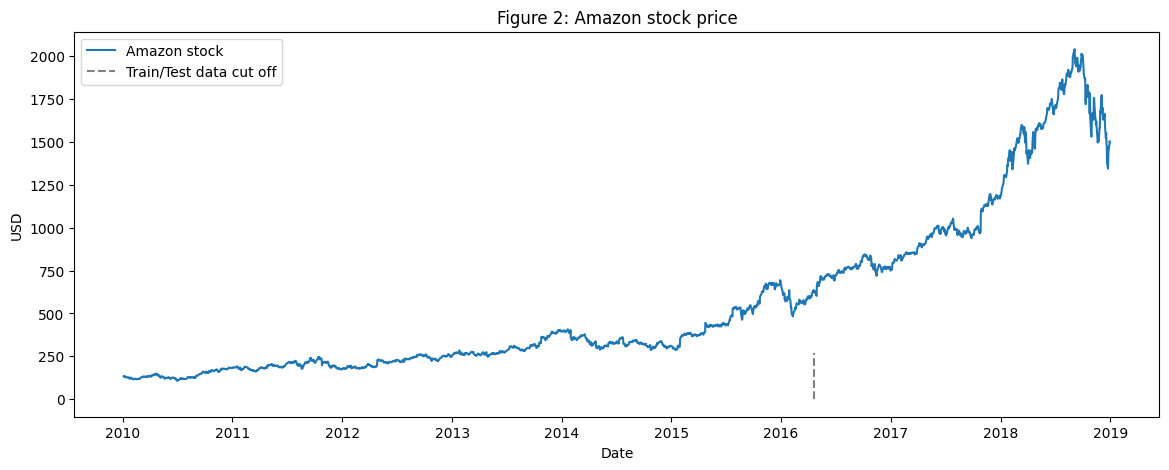

In [13]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Amazon stock')
plt.vlines(datetime.date(2016,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Amazon stock price')
plt.legend()
plt.show()

## FEATURE ENGINEERING

In [14]:
def get_technical_indicators(dataset): # function to generate feature technical indicators
  
  # Create 7 and 21 days Moving Average
  dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
  dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

  # Create MACD
  dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
  dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
  dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

  # Create Boolinger Bands
  dataset['20sd'] = dataset['Close'].rolling(window=20).std()
  dataset['upper_band'] = (dataset['Close'].rolling(window=20).mean()) + (dataset['20sd']*2)
  dataset['lower_band'] = (dataset['Close'].rolling(window=20).mean()) - (dataset['20sd']*2)

  # Create Exponential moving average
  dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

  # Create Momentum
  dataset['momentum'] = (dataset['Close']/100)-1

  return dataset

**Momentum** -> measurement of the speed of price change as movement for a particular asset

**Momentum = V-Vx where:**

**V = Latest price**

**Vx = Closing price**

**x = Number of days ago** 

In [15]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)

In [16]:
dataset_TI_df.head()

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,NaN,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,NaN,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,NaN,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,NaN,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,NaN,NaN,133.520004,NaN


In [17]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

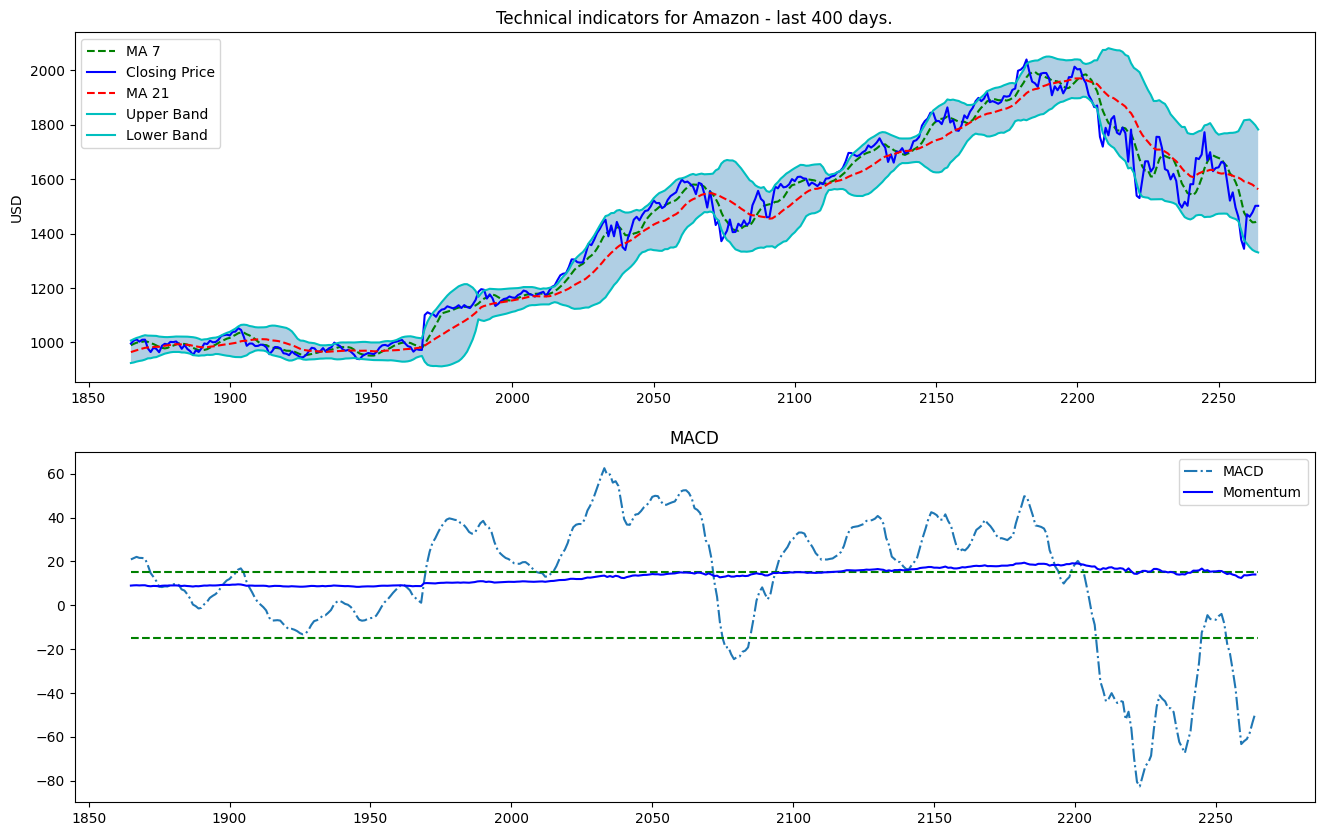

In [18]:
plot_technical_indicators(dataset_TI_df, 400)

## ANALYSIS OF TIME SERIES USING FOURIER TRANSFORM

In [19]:
data_FT = dataset_ex_df[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

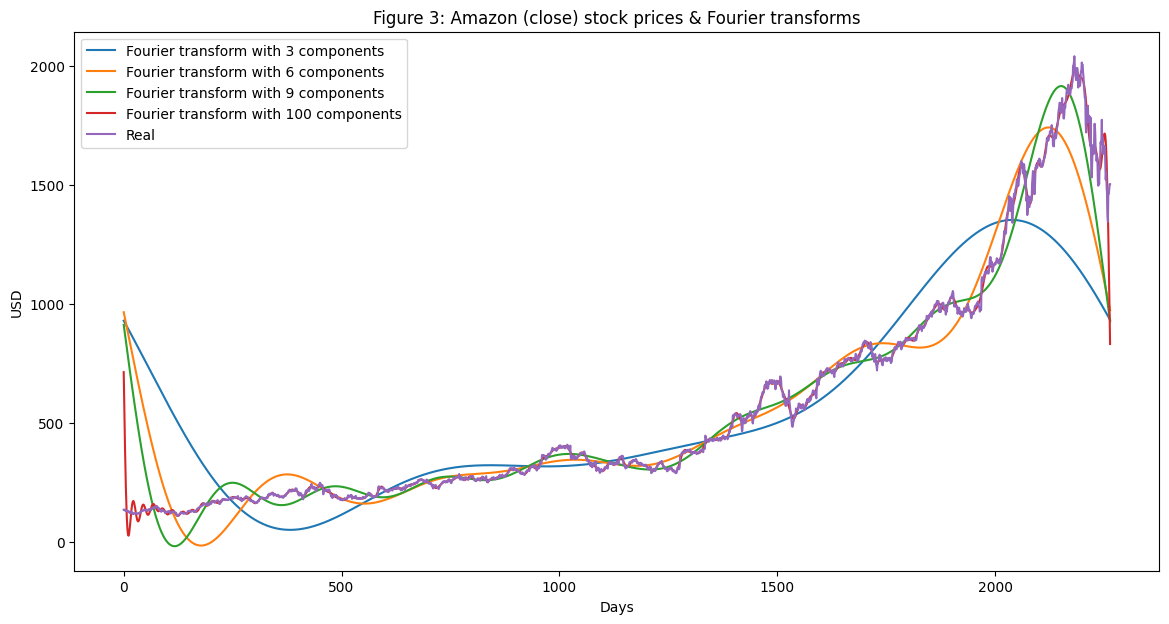

In [20]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Amazon (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [21]:
def get_fourier(dataset):
    data_FT = dataset[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    dataset['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset

In [22]:
dataset_TI_df = get_fourier(dataset_ex_df)

In [23]:
dataset_TI_df.head(30)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,NaN,133.520004,NaN
5,2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,NaN,130.309998,NaN
6,2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,NaN,127.349998,NaN
7,2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911,129.110001,NaN,129.110001,NaN
8,2010-01-14,129.139999,130.380005,126.400002,127.349998,9774900,129.984286,NaN,130.496376,129.999802,-0.496574,NaN,NaN,NaN,127.879659,0.2735,127.349998,NaN,127.349998,NaN
9,2010-01-15,129.179993,129.649994,127.059998,127.139999,15376500,129.254285,NaN,130.033228,129.457870,-0.575358,NaN,NaN,NaN,127.386544,0.2714,127.139999,NaN,127.139999,NaN


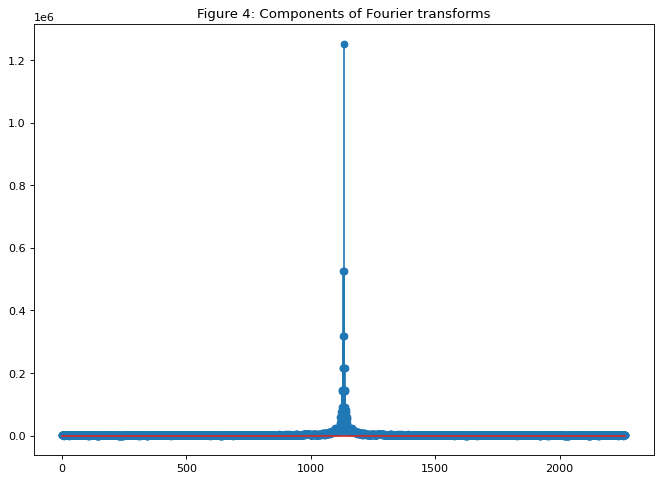

In [24]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7),dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## ARIMA

ARIMA as a feature:

Autoregressive Integrated Moving Average (ARIMA) — This was one of the most popular techniques for predicting future values of time series data (in the pre-neural networks ages). Let’s add it and see if it comes off as an important predictive feature.

ARIMA is a technique for predicting time series data. We will show how to use it, and all though ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.

ARIMA is an acronym. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

1. AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

2. I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

3. MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order. d: The number of times that the raw observations are differenced, also called the degree of differencing. q: The size of the moving average window, also called the order of moving average.



#### STEPS FOR ARIMA

1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.

2. The model is prepared on the training data by calling the fit() function.

3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.



In [25]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2265
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9247.127
Date:                Fri, 02 Jun 2023   AIC                          18506.254
Time:                        04:20:39   BIC                          18540.604
Sample:                             0   HQIC                         18518.788
                               - 2265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0250      0.008     -3.268      0.001      -0.040      -0.010
ar.L2          0.0018      0.007      0.256      0.798      -0.012       0.016
ar.L3         -0.0274      0.008     -3.505      0.0

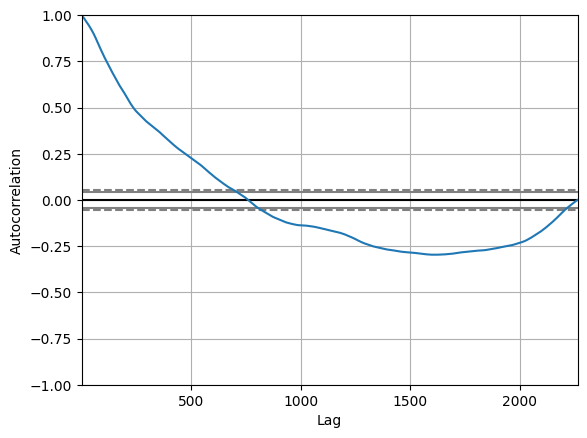

<Figure size 800x560 with 0 Axes>

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [27]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

dataset_TI_df['ARIMA'] = pd.DataFrame(predictions)

In [28]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 558.310


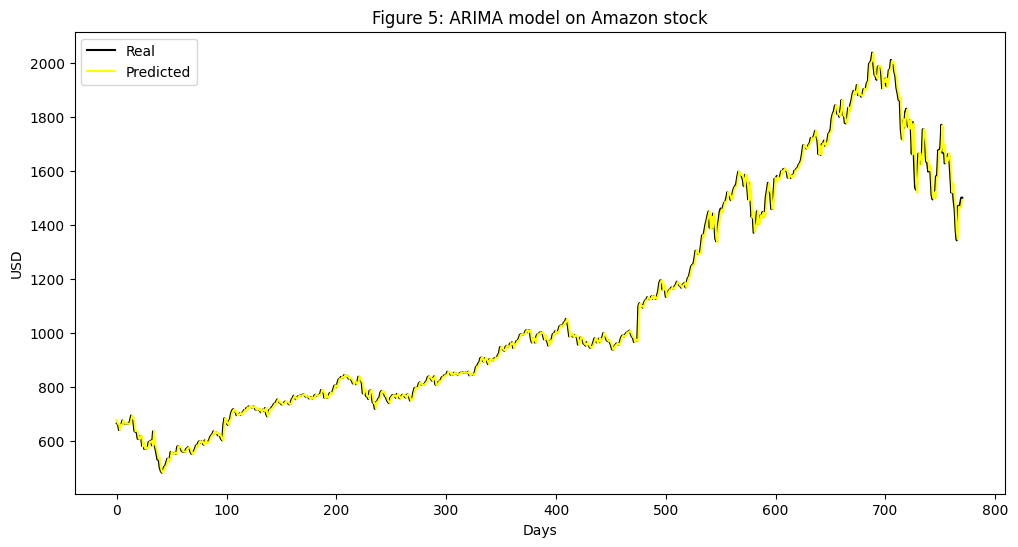

In [29]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Amazon stock')
plt.legend()
plt.show()

In [30]:
dataset_ex_df.head(8)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,677.897491,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,663.596692,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,662.984084,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,639.695373,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,660.141132,133.520004,NaN
5,2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,658.517020,130.309998,NaN
6,2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,676.090400,127.349998,NaN
7,2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911,129.110001,668.734754,129.110001,NaN


In [31]:
print('Total dataset has {} samples, and {} features.'.format(dataset_ex_df.shape[0], \
                                                              dataset_ex_df.shape[1]))

Total dataset has 2265 samples, and 20 features.


### FINDING IMPORTANT FEATURES USING XGBOOST

In [32]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:,1:19]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [33]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

     

In [34]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
     

In [35]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [36]:
eval_result = regressor.evals_result()
     

In [37]:

training_rounds = range(len(eval_result['validation_0']['rmse']))
     

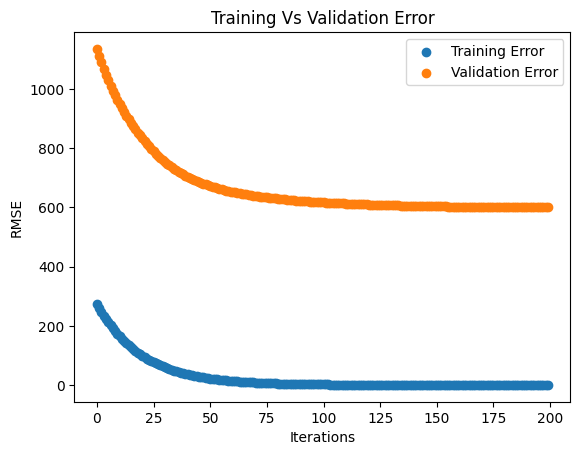

In [38]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

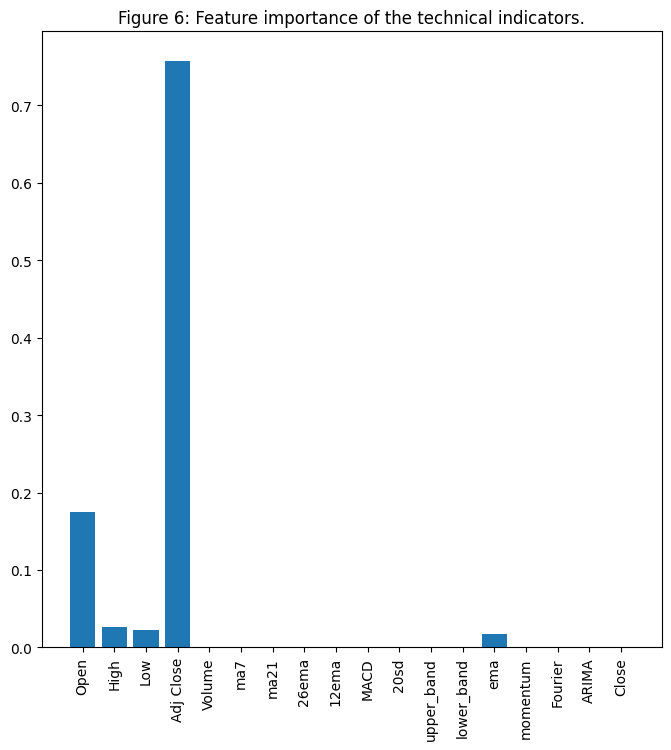

In [39]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

## LSTM

In [40]:
#1. take dataframe and drop na
dataset_lstm_df = dataset_TI_df.drop(columns='Date')
dataset_lstm_df.head(7)

,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,677.897491,133.899994,NaN
1,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,663.596692,134.690002,NaN
2,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,662.984084,132.250000,NaN
3,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,639.695373,130.000000,NaN
4,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,660.141132,133.520004,NaN
5,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,658.517020,130.309998,NaN
6,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,676.090400,127.349998,NaN


In [41]:
print('Total dataset has {} samples, and {} features.'.format(dataset_lstm_df.shape[0], \
                                                              dataset_lstm_df.shape[1]))

Total dataset has 2265 samples, and 19 features.


In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
     

In [44]:
#creating test, train and validate trains
train, validate, test = np.split(dataset_lstm_df.sample(frac=1), [int(.6*len(dataset_lstm_df)), int(.8*len(dataset_lstm_df))])


In [45]:
open_training = train.iloc[:, 1:2].values

In [46]:
#normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(60,450): 
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])
    
#Code ref: https://github.com/LiamConnell/deep-algotrading
     

In [47]:
features_set_1, labels_1 = np.array(features_set_1), np.array(labels_1)
features_set_1 = np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

In [48]:
#training it
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model.fit(features_set_1, labels_1, epochs = 100, batch_size = 32,validation_data = (features_set_1, labels_1))


Epoch 1/100
13/13 [==============================] - 17s 86ms/step - loss: 0.0754 - mean_absolute_error: 0.1976 - val_loss: 0.0681 - val_mean_absolute_error: 0.2149
Epoch 2/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0701 - mean_absolute_error: 0.2042 - val_loss: 0.0673 - val_mean_absolute_error: 0.1921
Epoch 3/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0698 - mean_absolute_error: 0.2135 - val_loss: 0.0703 - val_mean_absolute_error: 0.1806
Epoch 4/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0669 - mean_absolute_error: 0.1973 - val_loss: 0.0665 - val_mean_absolute_error: 0.2098
Epoch 5/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0664 - mean_absolute_error: 0.1985 - val_loss: 0.0658 - val_mean_absolute_error: 0.1965
Epoch 6/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0656 - mean_absolute_error: 0.1979 - val_loss: 0.0655 - val_mean_absolute_error: 0.2044
Epoch 7/100
13/

In [49]:
#TESTING THE MODEL
open_testing_processed = test.iloc[:, 1:2].values

In [50]:
#convert test data to right format
open_total = pd.concat((train['Open'], test['Open']), axis=0)

In [51]:
test_inputs = open_total[len(open_total) - len(test) - 60:].values

In [52]:
#scaling data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
     

In [53]:
test_features = []
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [54]:
test_features = np.array(test_features)
test_features.shape
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
     

In [55]:
#make predictions
predictions = model.predict(test_features)
     

3/3 [==============================] - 2s 12ms/step


In [56]:
predictions = scaler.inverse_transform(predictions)

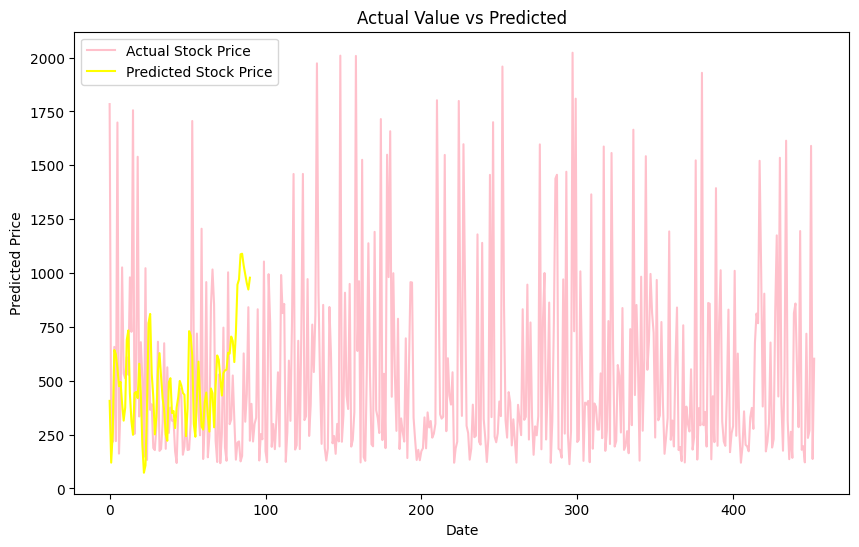

In [57]:
# plot the prediction model for the number of test days and train days
plt.figure(figsize=(10,6))
plt.plot(open_testing_processed, color='pink', label='Actual Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Stock Price')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


This wasn't a great result with one feature so let's try using more features and then train them on LSTM model

USING 5FEATURES :

USING THE BEST 5 FEATURES FROM THE RESULT OF THE XGBOOST. ITS QUITE OBVIOUS THAT A SINGLE FEATURE WILL NOT WORK SO WE USE THE 6 FEATURES THAT COULD GENERATE THE BEST OUTCOME FROM XGBOOST

In [58]:
dataset = dataset_ex_df[['Open', 'Close','High','Adj Close','Low']]
     

In [59]:
dataset.head()

,Open,Close,High,Adj Close,Low
0,136.250000,133.899994,136.610001,133.899994,133.139999
1,133.429993,134.690002,135.479996,134.690002,131.809998
2,134.600006,132.250000,134.729996,132.250000,131.649994
3,132.009995,130.000000,132.320007,130.000000,128.800003
4,130.559998,133.520004,133.679993,133.520004,129.029999


In [60]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [61]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [63]:
np.random.seed(10)

In [64]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])

In [65]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [66]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

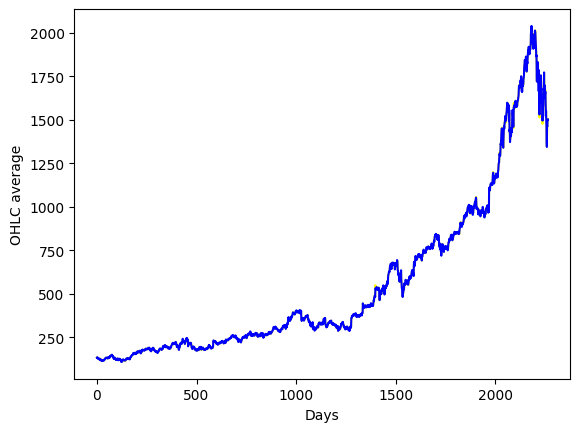

In [67]:
# PLOTTING All INDICATORS IN PLOT
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()


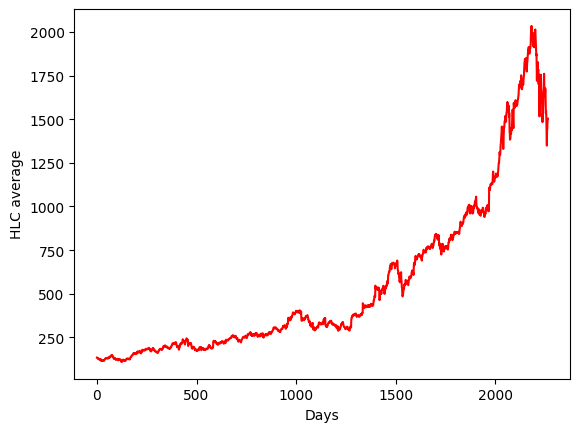

In [68]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()

     

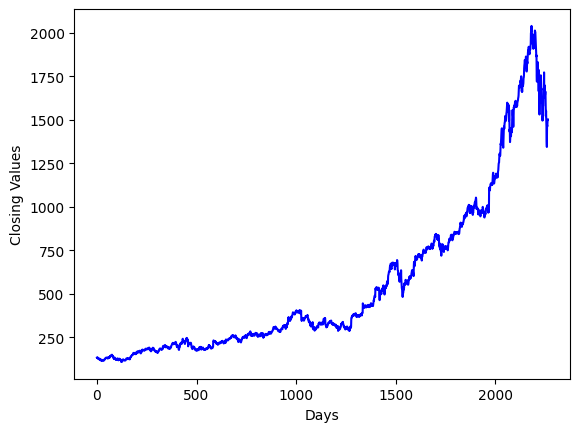

In [69]:
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [70]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
     

In [71]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [72]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)
     

In [73]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [74]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [75]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) # Try mae, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
1696/1696 - 13s - loss: 0.1046 - mae: 0.2188 - 13s/epoch - 8ms/step
Epoch 2/50
1696/1696 - 7s - loss: 0.0777 - mae: 0.1882 - 7s/epoch - 4ms/step
Epoch 3/50
1696/1696 - 7s - loss: 0.0667 - mae: 0.1836 - 7s/epoch - 4ms/step
Epoch 4/50
1696/1696 - 7s - loss: 0.0608 - mae: 0.1818 - 7s/epoch - 4ms/step
Epoch 5/50
1696/1696 - 7s - loss: 0.0574 - mae: 0.1818 - 7s/epoch - 4ms/step
Epoch 6/50
1696/1696 - 7s - loss: 0.0551 - mae: 0.1816 - 7s/epoch - 4ms/step
Epoch 7/50
1696/1696 - 7s - loss: 0.0535 - mae: 0.1817 - 7s/epoch - 4ms/step
Epoch 8/50
1696/1696 - 7s - loss: 0.0522 - mae: 0.1813 - 7s/epoch - 4ms/step
Epoch 9/50
1696/1696 - 7s - loss: 0.0512 - mae: 0.1808 - 7s/epoch - 4ms/step
Epoch 10/50
1696/1696 - 7s - loss: 0.0503 - mae: 0.1801 - 7s/epoch - 4ms/step
Epoch 11/50
1696/1696 - 7s - loss: 0.0494 - mae: 0.1794 - 7s/epoch - 4ms/step
Epoch 12/50
1696/1696 - 8s - loss: 0.0485 - mae: 0.1785 - 8s/epoch - 5ms/step
Epoch 13/50
1696/1696 - 7s - loss: 0.0477 - mae: 0.1774 - 7s/epoch - 4m

In [76]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

36/36 [==============================] - 1s 4ms/step - loss: 0.0235 - mae: 0.1530
Mean Absolute Error for Y: [0.023488178849220276, 0.15298964083194733]


In [77]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
     


18/18 [==============================] - 1s 5ms/step


In [78]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
     

In [79]:
# TRAINING rmse
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' % (trainScore))
     

Train : 244.58


In [80]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 294.90


In [81]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict
     

In [83]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict
     

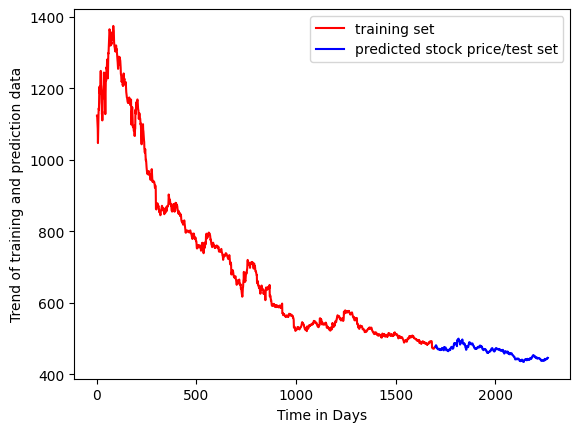

In [84]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()

In [85]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

1/1 [==============================] - 0s 21ms/step
Last Day Value: 446.4202575683594
Next Day Value: 293.4239807128906


The value was found relying on OHLC values. As the days increase the value is decreasing or rather stabilizing. However this is a wrong way of going about since amazon prices are still booming not decreasing.

